# import libs

In [21]:
import os
import socket
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from FCNN import TwoInputFCNN as FCNN
from sklearn.preprocessing import MinMaxScaler


# import data

In [22]:
# paths pre-setting
if 'gput' in socket.gethostname() or 'hpc' in socket.gethostname():
    label_root = '/home/sxy841/ERIE/silicone/output'
    model_root = '/home/sxy841/ERIE/silicone/Track-Shuyuan-2023-06-13/videos'
else:
    label_root = '/home/ysy/ERIE/single_psm_manipulation_dataset/output'
    model_root = '/home/ysy/ERIE/Track-Shuyuan-2023-06-13/videos'

model_name = 'DLC_resnet50_TrackJun13shuffle1_50000'


In [23]:
# pre setting training sets
training_sets = ['C_M1_T1_4', 'C_M1_T1_7', 'C_M1_T1_3', 'C_M1_T1_6',
                 'R2_M1_T1_6', 'R2_M1_T1_7', 'R2_M1_T1_3', 'R2_M1_T1_5',
                 'L2_M1_T1_3', 'L2_M1_T1_4', 'L2_M1_T1_5', 'L2_M1_T1_7',
                 'Z2_M1_T1_1', 'M3_Z2_NF', 'M5_Z2_NF', 'M12_Z2_NF']

# initial arrays
X_train_L = np.zeros((0, 16))
X_train_R = np.zeros((0, 16))
y_train = np.zeros((0, 3))

for set in tqdm(training_sets):
    # load from files
    labels = np.genfromtxt(os.path.join(
        label_root, set, 'labels_30hz.txt'), delimiter=',')
    coordinates_L = pd.read_hdf(os.path.join(
        model_root, f'{set}_L_h264{model_name}.h5'))
    coordinates_R = pd.read_hdf(os.path.join(
        model_root, f'{set}_R_h264{model_name}.h5'))

    # unify size
    frames = min(len(labels), len(coordinates_L), len(coordinates_R))

    # drop and convert
    coordinates_L = coordinates_L.filter(
        regex='^(?!.*likelihood).*$', axis=1).to_numpy()[:frames]
    coordinates_R = coordinates_R.filter(
        regex='^(?!.*likelihood).*$', axis=1).to_numpy()[:frames]
    labels = labels[:frames, 7:10]

    X_train_L = np.vstack(
        (X_train_L, MinMaxScaler().fit_transform(coordinates_L)))
    X_train_R = np.vstack(
        (X_train_R, MinMaxScaler().fit_transform(coordinates_R)))
    y_train = np.vstack((y_train, MinMaxScaler().fit_transform(labels)))


100%|██████████| 16/16 [00:05<00:00,  2.76it/s]


In [24]:
X_train_L.shape, X_train_R.shape, y_train.shape

((56098, 16), (56098, 16), (56098, 3))

In [25]:
# pre setting validation sets
val_sets = ['C_M1_T1_1', 'C_M1_T1_5', 'R2_M1_T1_2', 'R2_M1_T1_4',
            'L2_M1_T1_6', 'L2_M1_T1_1', 'Z2_M1_T1_2', 'M7_Z2_NF']

# initial arrays
X_val_L = np.zeros((0, 16))
X_val_R = np.zeros((0, 16))
y_val = np.zeros((0, 3))

for set in tqdm(val_sets):
    # load from files
    labels = np.genfromtxt(os.path.join(
        label_root, set, 'labels_30hz.txt'), delimiter=',')
    coordinates_L = pd.read_hdf(os.path.join(
        model_root, f'{set}_L_h264{model_name}.h5'))
    coordinates_R = pd.read_hdf(os.path.join(
        model_root, f'{set}_R_h264{model_name}.h5'))

    # unify size
    frames = min(len(labels), len(coordinates_L), len(coordinates_R))

    # drop and convert
    coordinates_L = coordinates_L.filter(
        regex='^(?!.*likelihood).*$', axis=1).to_numpy()[:frames]
    coordinates_R = coordinates_R.filter(
        regex='^(?!.*likelihood).*$', axis=1).to_numpy()[:frames]
    labels = labels[:frames, 7:10]

    X_val_L = np.vstack(
        (X_val_L, MinMaxScaler().fit_transform(coordinates_L)))
    X_val_R = np.vstack(
        (X_val_R, MinMaxScaler().fit_transform(coordinates_R)))
    y_val = np.vstack((y_val, MinMaxScaler().fit_transform(labels)))


100%|██████████| 8/8 [00:02<00:00,  2.74it/s]


In [26]:
X_val_L.shape, X_val_R.shape, y_val.shape

((28107, 16), (28107, 16), (28107, 3))

# Trainning and validation

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = FCNN(input_dim=X_train_L.shape[1], hidden_dim=16, output_dim=y_train.shape[1],
           device=device, weights=[0.5, 1.0, 0.5], num_hidden_layers=4, batch_size=32,
            l2_reg=1e-4, lr=0.0001, random_seed=42)
net.train(X_train_R, np.zeros(X_train_L.shape), y_train, X_val_R, np.zeros(X_val_L.shape),
          y_val, epochs=200, use_tqdm=True, save_loss=True)


Epoch 199: 100%|██████████| 350800/350800 [19:12<00:00, 304.35it/s, loss=0.00778] 


# Retrieve model

In [28]:
net_name = input()

In [29]:
import json

with open(f'results/losses_{net_name}.json', 'r') as f:
    params = json.load(f)

input_dim = params["input_dim"]
hidden_dim = params["hidden_dim"]
output_dim = params["output_dim"]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weights = params["weights"]
num_hidden_layers = params["num_hidden_layers"]
lr = params["lr"]
batch_size = params["batch_size"]
random_seed = params["random_seed"]

net = FCNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim,
           device=device, weights=weights, num_hidden_layers=num_hidden_layers,
           batch_size=batch_size, lr=lr, random_seed=random_seed)


In [30]:
net.load_state_dict(torch.load(
    f'models/best_model_{net_name}.pth', map_location=device))


# Retrieve model (test)

In [33]:
net_name = input()

In [35]:
import json

with open(f'results/losses_{net_name}.json', 'r') as f:
    params = json.load(f)

input_dim = params["input_dim"]
hidden_dim = params["hidden_dim"]
output_dim = params["output_dim"]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weights = params["weights"]
num_hidden_layers = params["num_hidden_layers"]
lr = params["lr"]
batch_size = params["batch_size"]
random_seed = params["random_seed"]

net_single = FCNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim,
           device=device, weights=weights, num_hidden_layers=num_hidden_layers,
           batch_size=batch_size, lr=lr, random_seed=random_seed)


In [36]:
net_single.load_state_dict(torch.load(
    f'models/best_model_{net_name}.pth', map_location=device))


# Test

Plot C_M1_T1_8: 


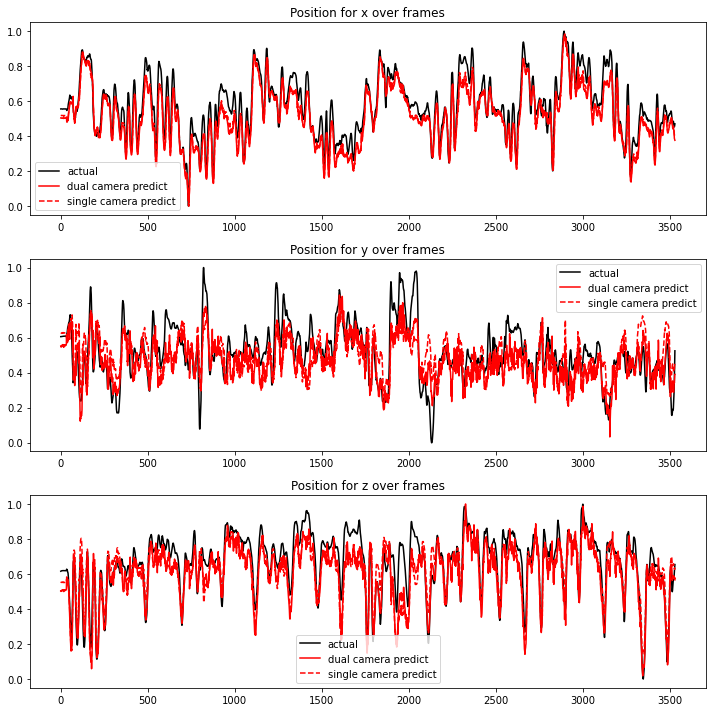

Plot M1_NF: 


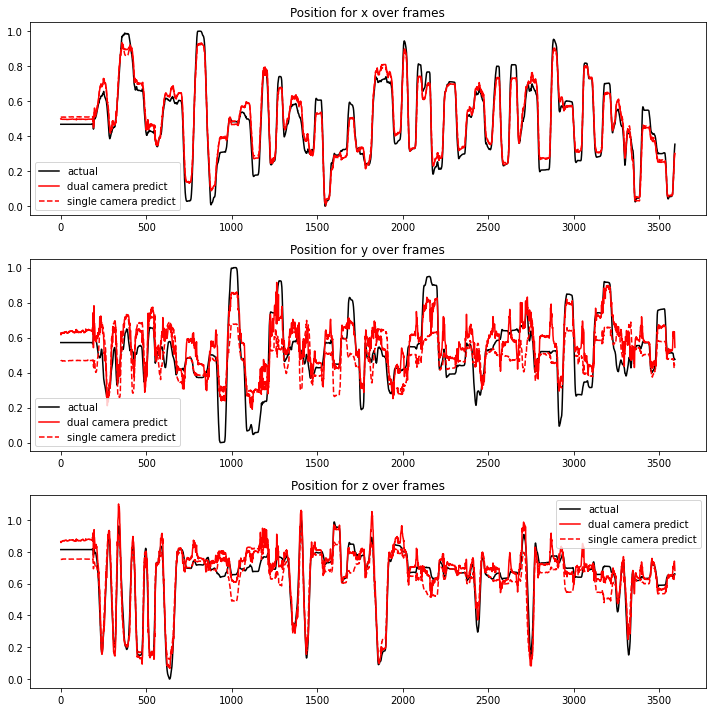

Plot M2_NF: 


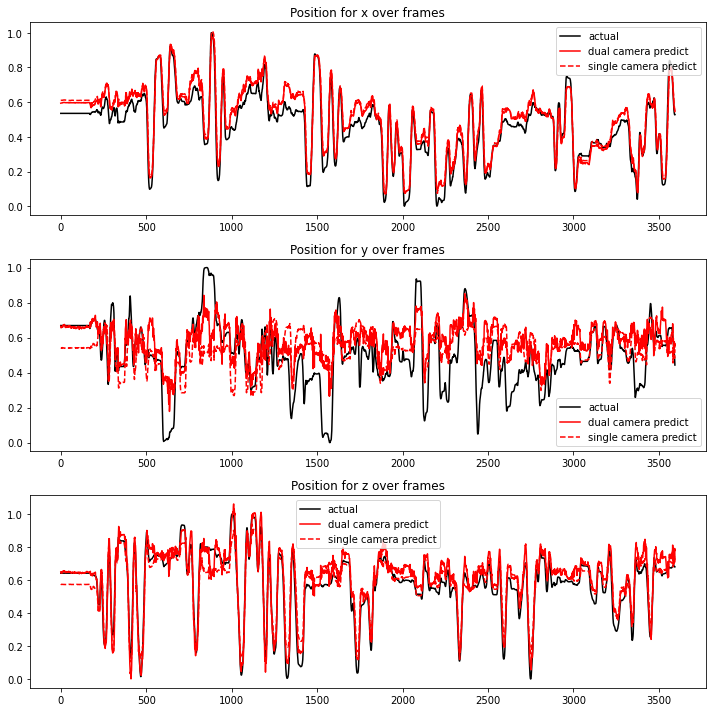

Plot R1_M1_T1_1: 


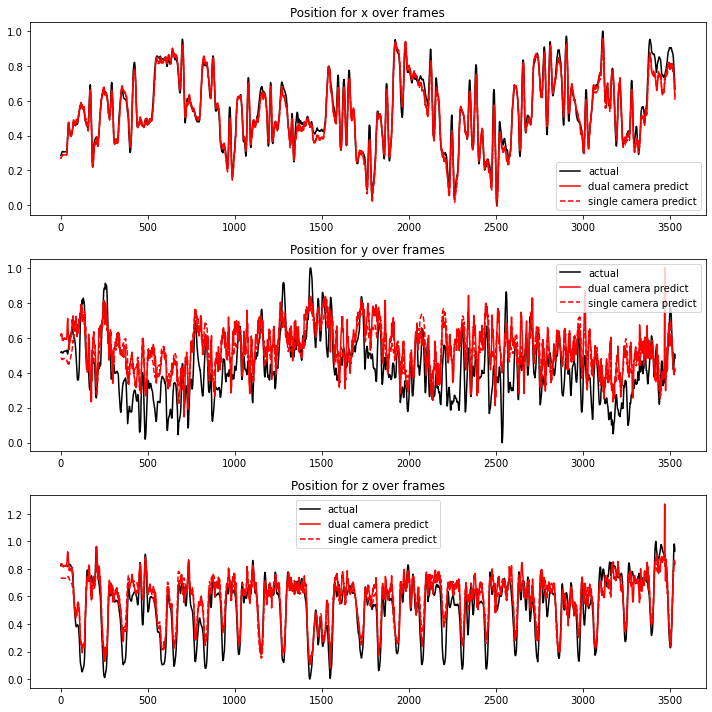

Plot R1_M1_T1_2: 


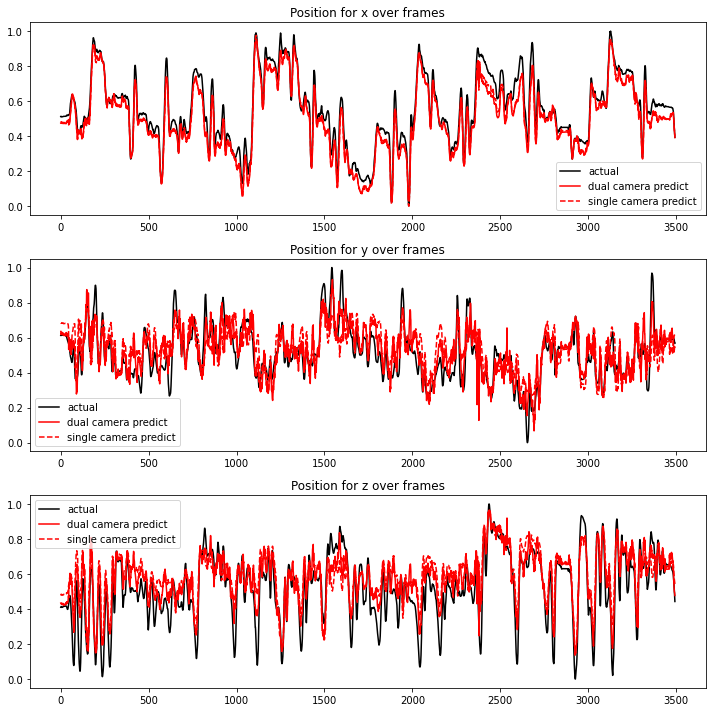

Plot R3_M1_T1_1: 


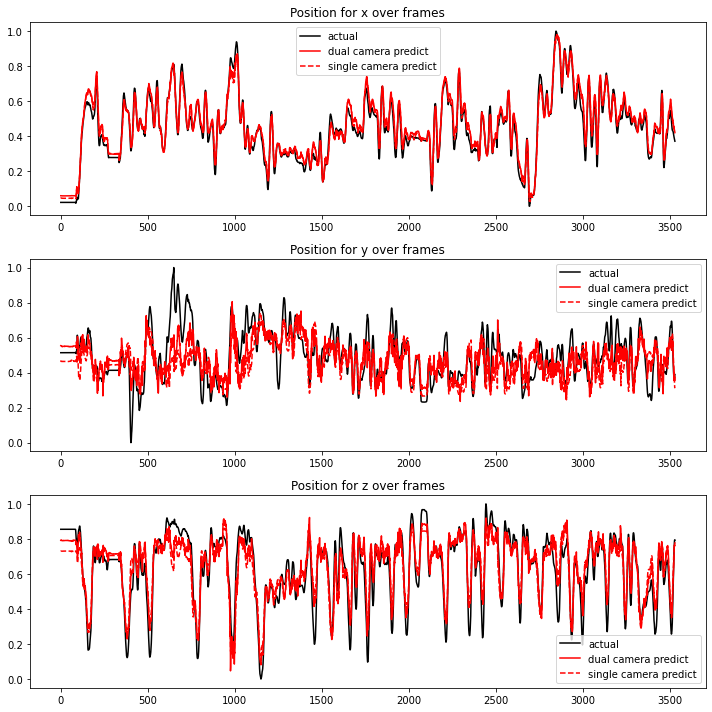

Plot R3_M1_T1_2: 


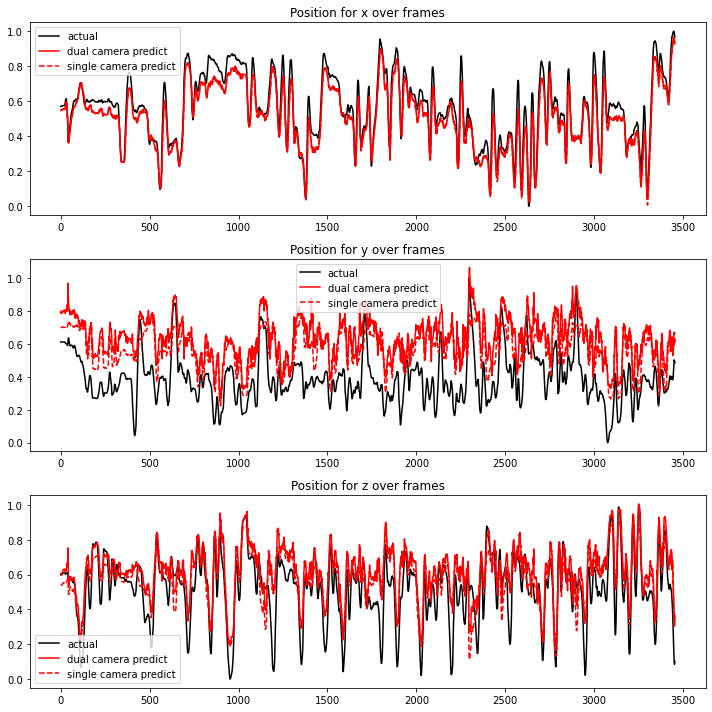

Plot L1_M1_T1_1: 


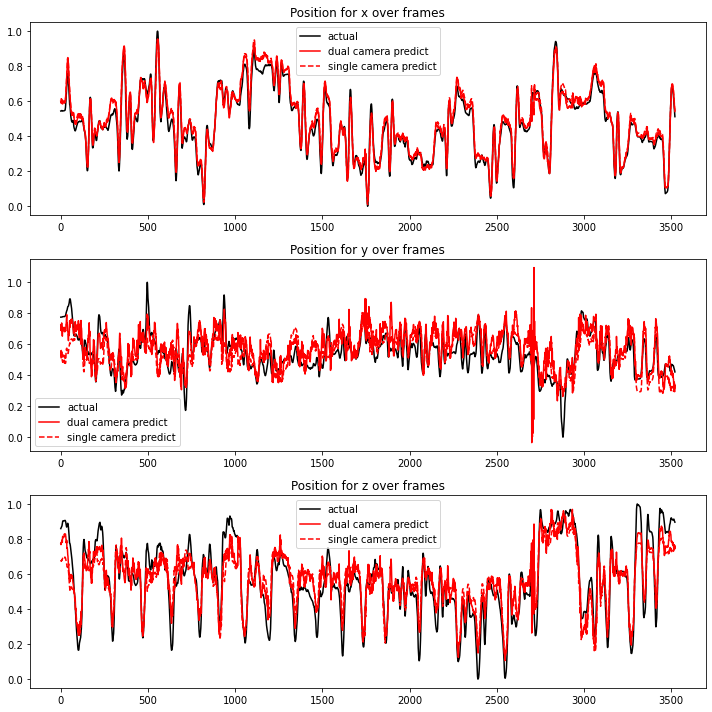

Plot L1_M1_T1_2: 


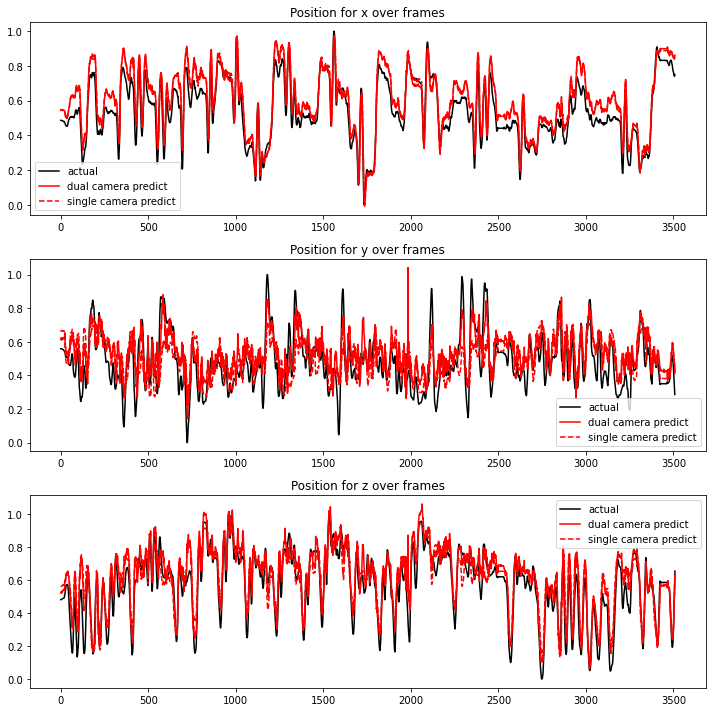

Plot L3_M1_T1_1: 


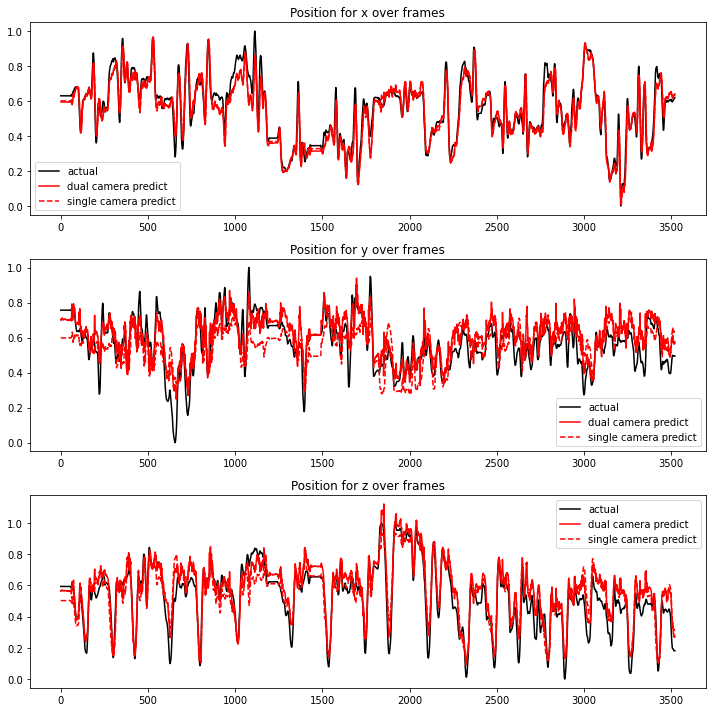

Plot L3_M1_T1_2: 


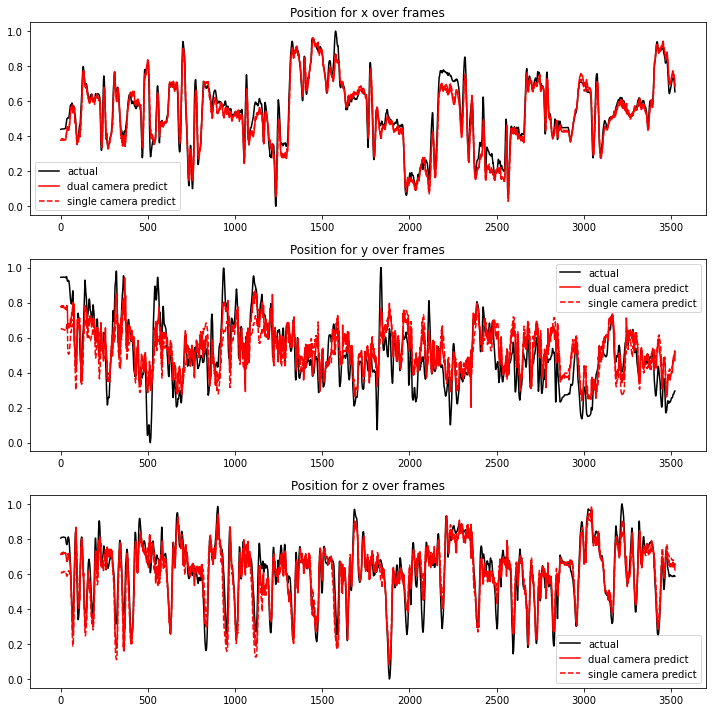

Plot Z1_M1_T1_1: 


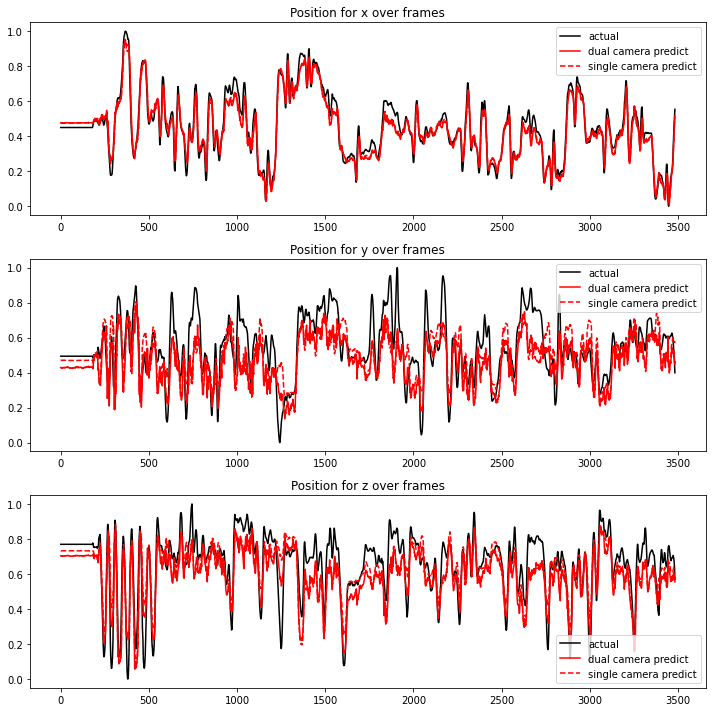

Plot Z3_M1_T1_1: 


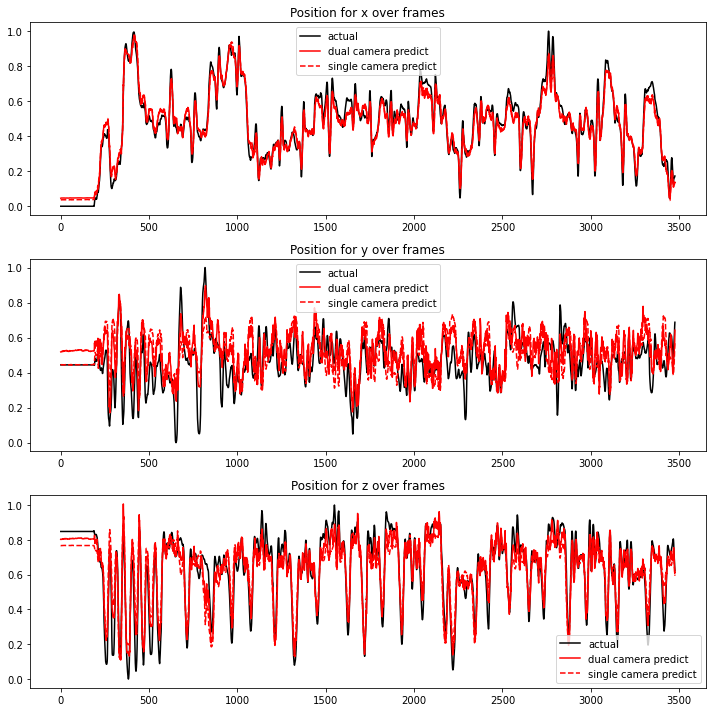

Plot R2_M1_T1_8: 


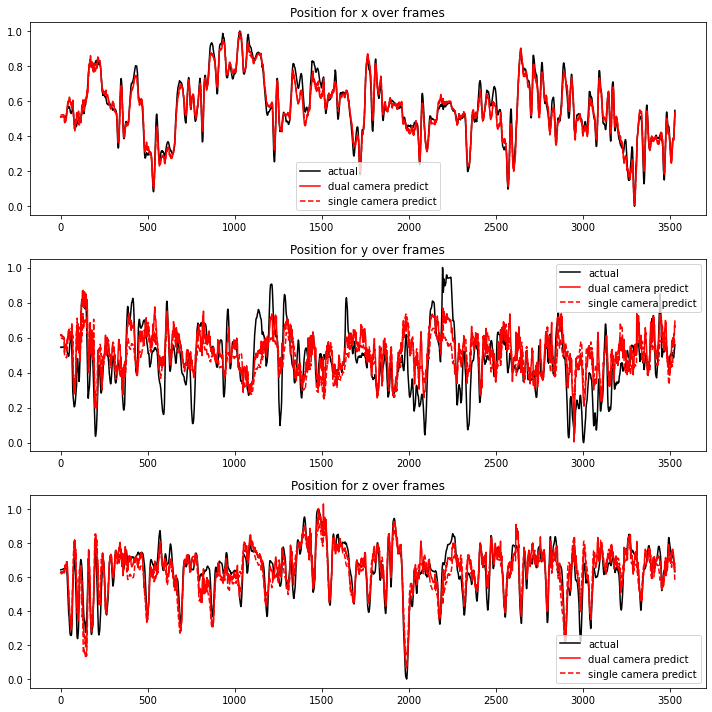

Plot M3_R2_NF: 


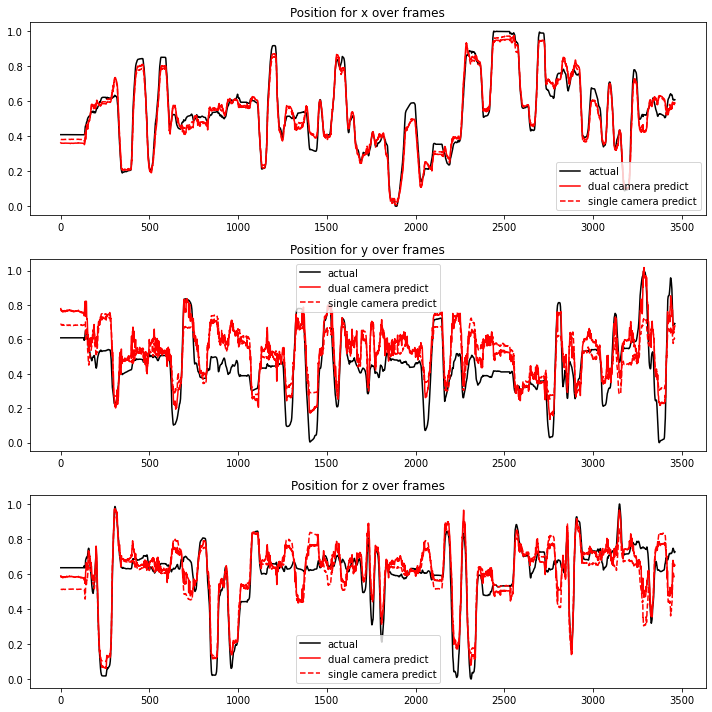

Plot M5_R2_NF: 


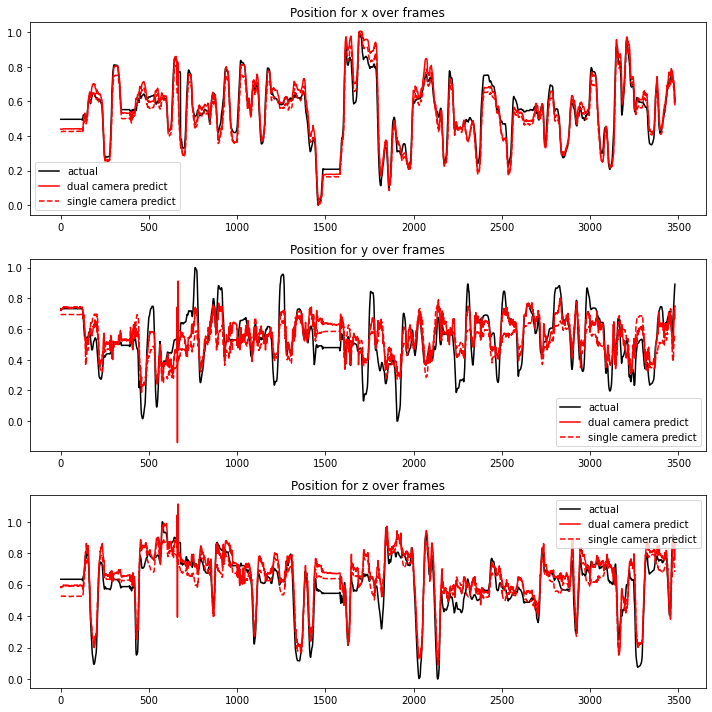

Plot M5_L2_NF: 


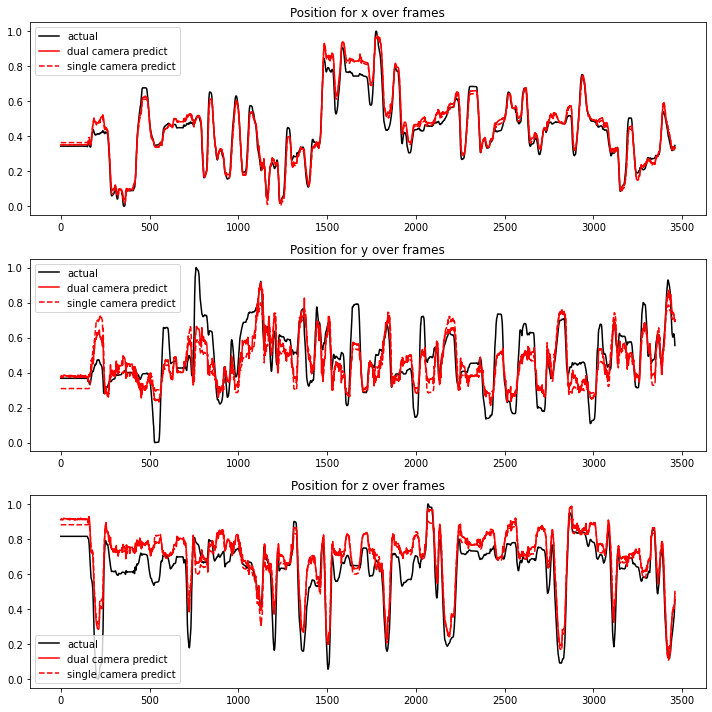

Plot M3_L2_NF: 


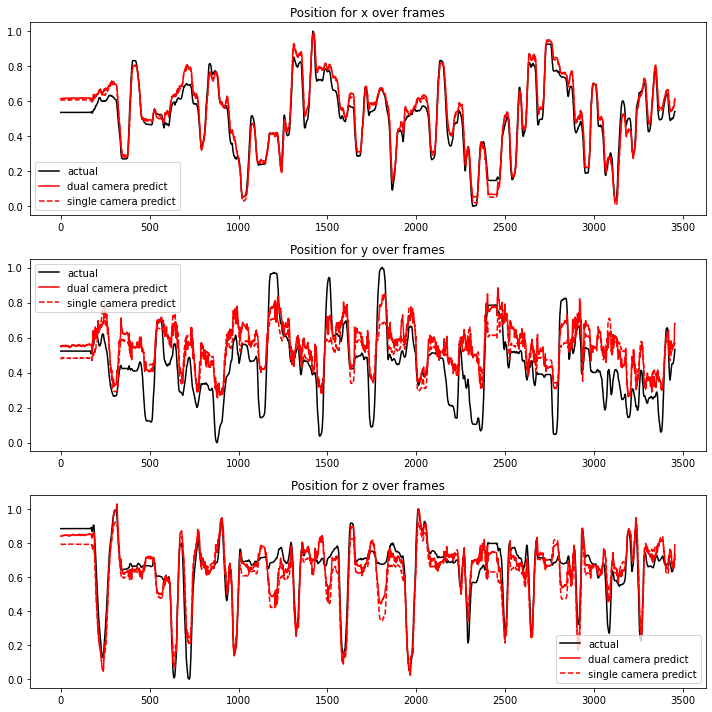

Plot M7_L2_NF: 


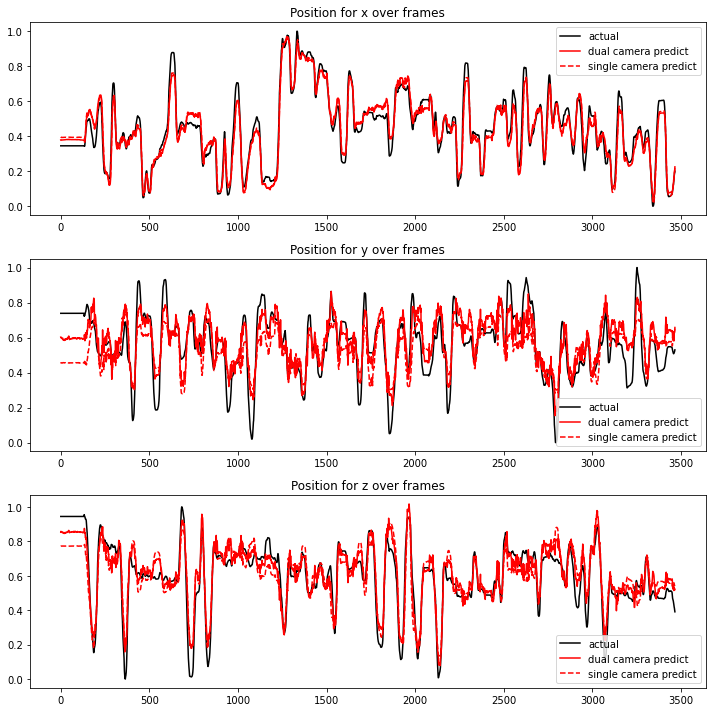

Plot Z2_M1_T1_5: 


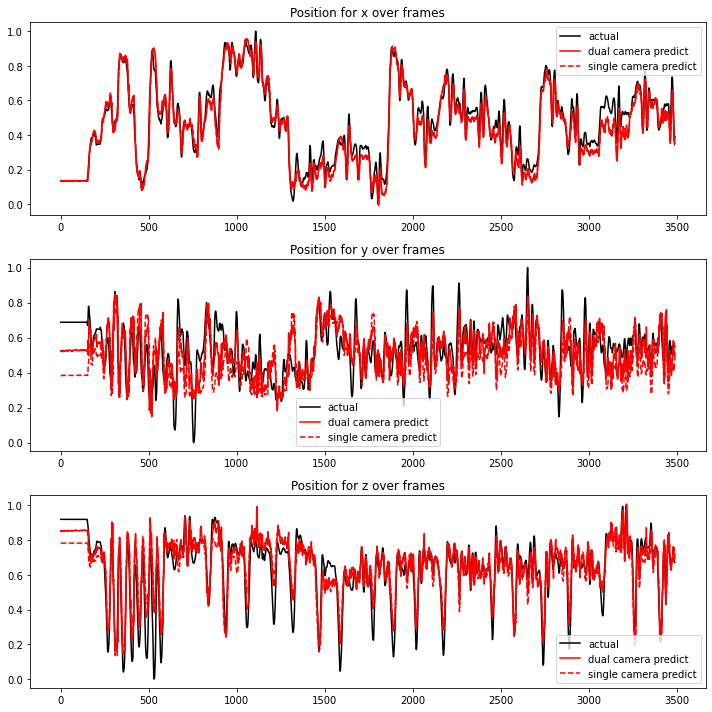

Plot M9_Z2_NF: 


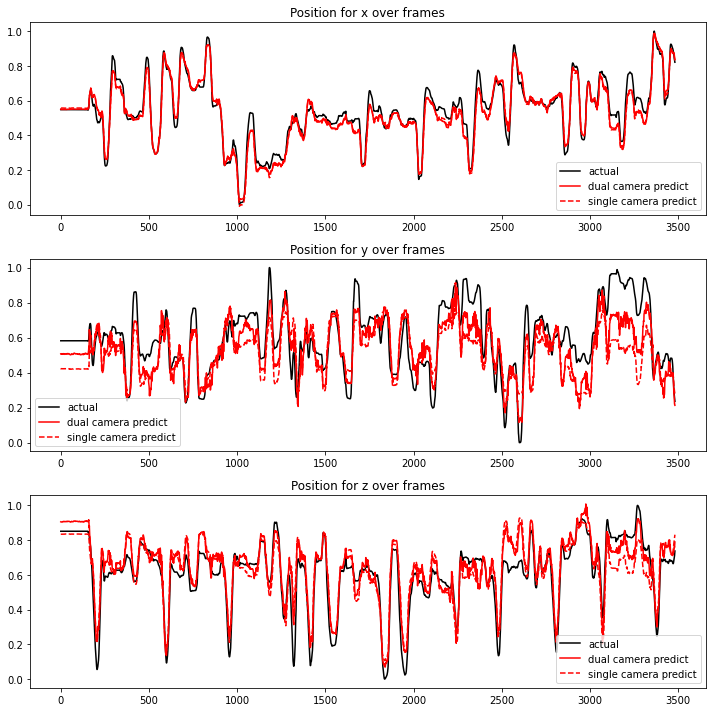

Plot M8_Z2_NF: 


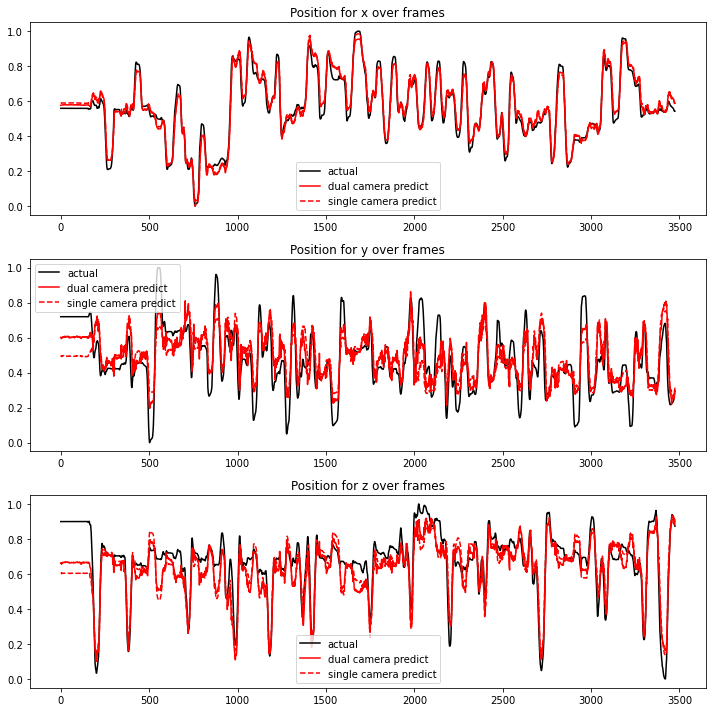

In [37]:
# pre setting test sets
test_sets = ['C_M1_T1_8', 'M1_NF', 'M2_NF', 'R1_M1_T1_1',
             'R1_M1_T1_2', 'R3_M1_T1_1', 'R3_M1_T1_2', 'L1_M1_T1_1',
             'L1_M1_T1_2', 'L3_M1_T1_1', 'L3_M1_T1_2', 'Z1_M1_T1_1',
             'Z3_M1_T1_1', 'R2_M1_T1_8', 'M3_R2_NF', 'M5_R2_NF',
             'M5_L2_NF', 'M3_L2_NF', 'M7_L2_NF', 'Z2_M1_T1_5',
             'M9_Z2_NF', 'M8_Z2_NF']

for set in test_sets:
    # load from files
    labels = np.genfromtxt(os.path.join(
        label_root, set, 'labels_30hz.txt'), delimiter=',')
    coordinates_L = pd.read_hdf(os.path.join(
        model_root, f'{set}_L_h264{model_name}.h5'))
    coordinates_R = pd.read_hdf(os.path.join(
        model_root, f'{set}_R_h264{model_name}.h5'))

    # unify size
    frames = min(len(labels), len(coordinates_L), len(coordinates_R))

    # drop and convert
    coordinates_L = coordinates_L.filter(
        regex='^(?!.*likelihood).*$', axis=1).to_numpy()[:frames]
    coordinates_R = coordinates_R.filter(
        regex='^(?!.*likelihood).*$', axis=1).to_numpy()[:frames]
    labels = labels[:frames, 7:10]

    X_test_L = MinMaxScaler().fit_transform(coordinates_L)
    X_test_R = MinMaxScaler().fit_transform(coordinates_R)
    y_test = MinMaxScaler().fit_transform(labels)
    y_pred = net.predict(X_test_R, X_test_L)
    y_pred_single = net_single.predict(X_test_R, np.zeros(X_test_L.shape))

    # save prediction
    # np.savetxt(f"labels/{set}.txt", y_pred, delimiter=",")

    print(f"Plot {set}: ")

    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(3, 1, figsize=(10, 10))
    titles = ['x', 'y', 'z']
    for i in range(3):
        ax[i].plot(range(y_test.shape[0]), y_test[:, i],
                   color='black', label='actual')
        ax[i].plot(range(y_test.shape[0]), y_pred[:, i],
                   color='red', label='dual camera predict')
        ax[i].plot(range(y_test.shape[0]), y_pred_single[:, i],
                   color='red', label='single camera predict', linestyle='--')
        ax[i].legend()
        ax[i].set_title(f'Position for {titles[i]} over frames')
    plt.tight_layout()
    plt.show()


# Demos

In [31]:
import json
import matplotlib.pyplot as plt
import glob
import numpy as np


def plot_loss(filter_params=None):
    # Get a list of files that match the pattern
    files = glob.glob('results/*.json')

    # Dimension names
    dim_names = ['x', 'y', 'z', 'Mean']

    # Determine the number of subplots from the loss dimension
    with open(files[0], 'r') as f:
        data = json.load(f)
    losses = data['losses'][0]  # Take first loss array as an example
    num_subplots = len(losses)  # Include plot for the mean loss

    # Create a subplot for each loss dimension
    fig, axs = plt.subplots(num_subplots, figsize=(12, 6 * num_subplots))

    # Ensure axs is a list even when num_subplots = 1
    if num_subplots == 1:
        axs = [axs]

    # List to store parameters of the files that passed the filter
    filtered_params_list = []
    files_passed_filter = []

    # Loop over each file
    for filename in files:
        # Load the data from the JSON file
        with open(filename, 'r') as f:
            data = json.load(f)

        # Extract the training parameters from the data
        params = {k: v for k, v in data.items() if k != 'losses'}

        # If filter is not None, skip this file if it does not match the filter
        if filter_params is not None and not all(item in params.items() for item in filter_params.items()):
            continue

        # If the file passed the filter, add its parameters and filename to the list
        if filter_params is None or all(item in params.items() for item in filter_params.items()):
            filtered_params_list.append(params)
            files_passed_filter.append(filename)

    # Determine common parameters
    common_params = filtered_params_list[0].copy()
    for params in filtered_params_list[1:]:
        keys_to_delete = []
        for k in common_params.keys():
            if common_params[k] != params[k]:
                keys_to_delete.append(k)
        for k in keys_to_delete:
            common_params.pop(k)

    # Loop over each file again to plot the data
    for params, filename in zip(filtered_params_list, files_passed_filter):
        # Load the data from the JSON file
        with open(filename, 'r') as f:
            data = json.load(f)

        # Extract the unique training parameters for this file
        unique_params = {k: v for k,
                         v in params.items() if k not in common_params}

        # Create a label for this line from the unique training parameters
        label = ', '.join(f'{key}: {value}' for key,
                          value in unique_params.items())

        # Extract loss values
        losses = data['losses']

        # Plot the loss values for each dimension
        for j in range(num_subplots):
            axs[j].plot([loss[j] for loss in losses], label=label)
            axs[j].set_title(f'Loss for {dim_names[j]} over iterations')
            axs[j].set_xlabel('Iteration')
            axs[j].set_ylabel('Loss')
            axs[j].grid(True)
            axs[j].legend()

    plt.tight_layout()
    plt.show()


bench parameters: 

{"input_dim": 16, "hidden_dim": 64, "output_dim": 3, "device": "cuda", "num_hidden_layers": 2, "lr": 0.001, "batch_size": 32}

In [ ]:
plot_loss()

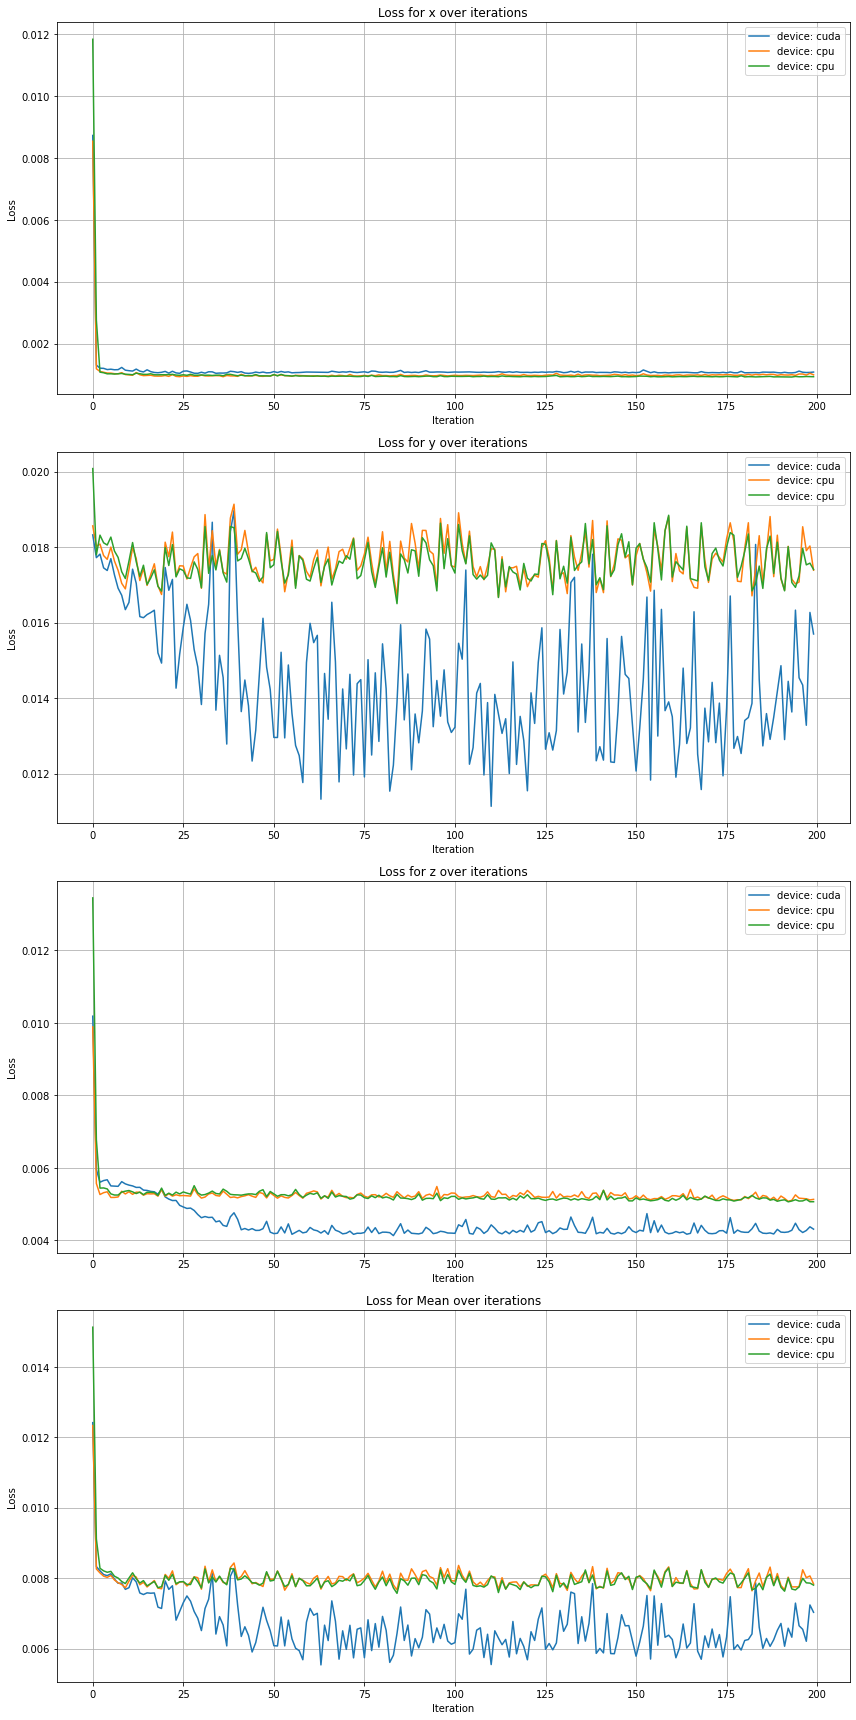

In [32]:
plot_loss(filter_params={"lr": 0.0001})

In [ ]:
# 绘制直方图
plt.hist(y_train, bins=30, edgecolor='black', label=['x', 'y', 'z'])

# 添加标题和标签
plt.title("Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")

# 添加图例
plt.legend()

# 显示图形
plt.show()
# 绘制箱线图
plt.boxplot(y_train, showfliers=False)

# 添加标题和标签
plt.title("Box Plot")
plt.xlabel("Data")

# 显示图形
plt.show()